In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score


In [2]:
df1 = pd.read_csv(('gradient_boost_optimise_results.csv' ))
print(df1)

          y_true    y_pred  y_transformed          lon         lat
0      -0.416573 -0.893819      -0.893819   733918.149 -2611525.25
1      -0.286116 -0.867605      -0.867605   733576.615 -2611507.22
2      -0.326302 -0.664411      -0.664411   733235.911 -2611485.23
3      -0.430061 -0.826153      -0.826153   732898.186 -2611471.29
4      -0.620153 -1.114811      -1.114811   732564.331 -2611446.62
...          ...       ...            ...          ...         ...
259002 -1.506235 -1.822296      -1.822296   503053.300 -2177707.38
259003 -0.783225 -0.870340      -0.870340   543295.125 -2177704.15
259004 -1.517741 -1.325385      -1.325385   321851.553 -2177701.95
259005 -2.651306 -2.529641      -2.529641 -1080456.310 -2177688.38
259006 -2.352128 -1.783645      -1.783645 -1155306.740 -2177675.01

[259007 rows x 5 columns]


In [10]:
df2 = df1[["y_true", "y_pred"]]
print(df2)

          y_true    y_pred
0      -0.416573 -0.893819
1      -0.286116 -0.867605
2      -0.326302 -0.664411
3      -0.430061 -0.826153
4      -0.620153 -1.114811
...          ...       ...
259002 -1.506235 -1.822296
259003 -0.783225 -0.870340
259004 -1.517741 -1.325385
259005 -2.651306 -2.529641
259006 -2.352128 -1.783645

[259007 rows x 2 columns]


In [17]:
df3 = 10**df2
print(df3)

          y_true    y_pred
0       0.383201  0.127697
1       0.517469  0.135642
2       0.471735  0.216565
3       0.371483  0.149227
4       0.239799  0.076770
...          ...       ...
259002  0.031172  0.015056
259003  0.164731  0.134791
259004  0.030357  0.047273
259005  0.002232  0.002954
259006  0.004445  0.016457

[259007 rows x 2 columns]


<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

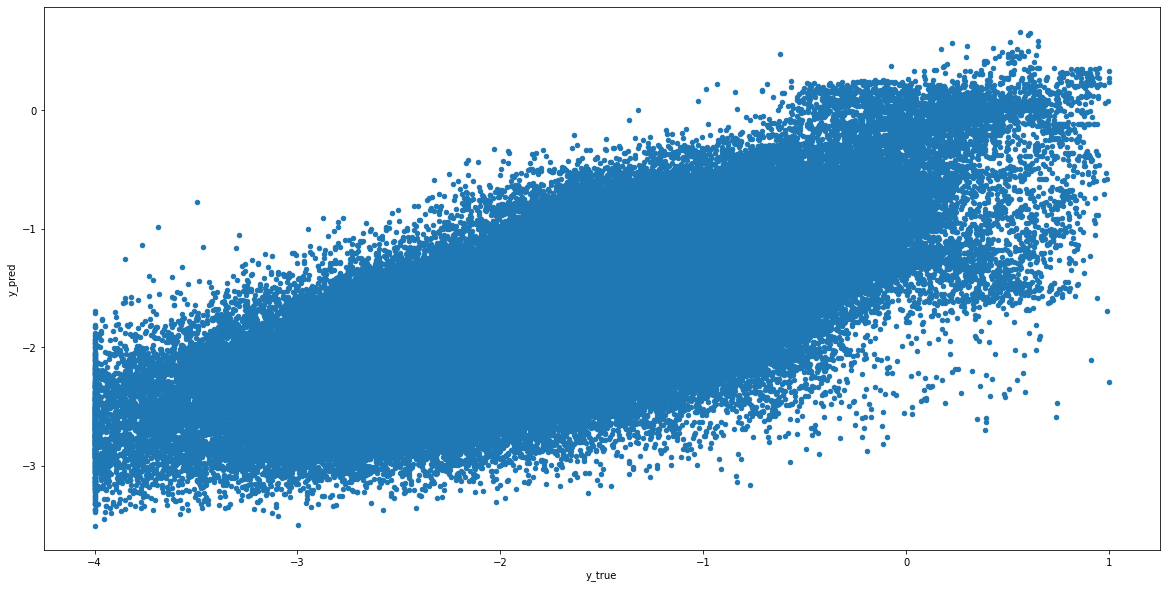

In [3]:
df1.plot.scatter(x="y_true", y="y_pred", figsize=(20,10))

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

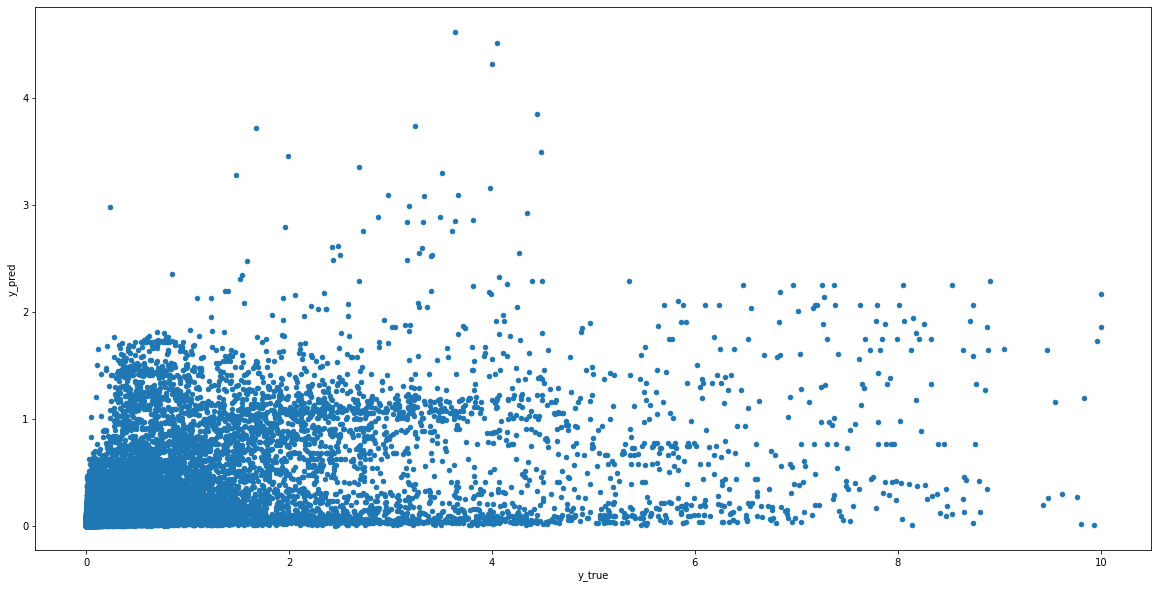

In [20]:
df3.plot.scatter(x="y_true", y="y_pred", figsize=(20,10))

In [4]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

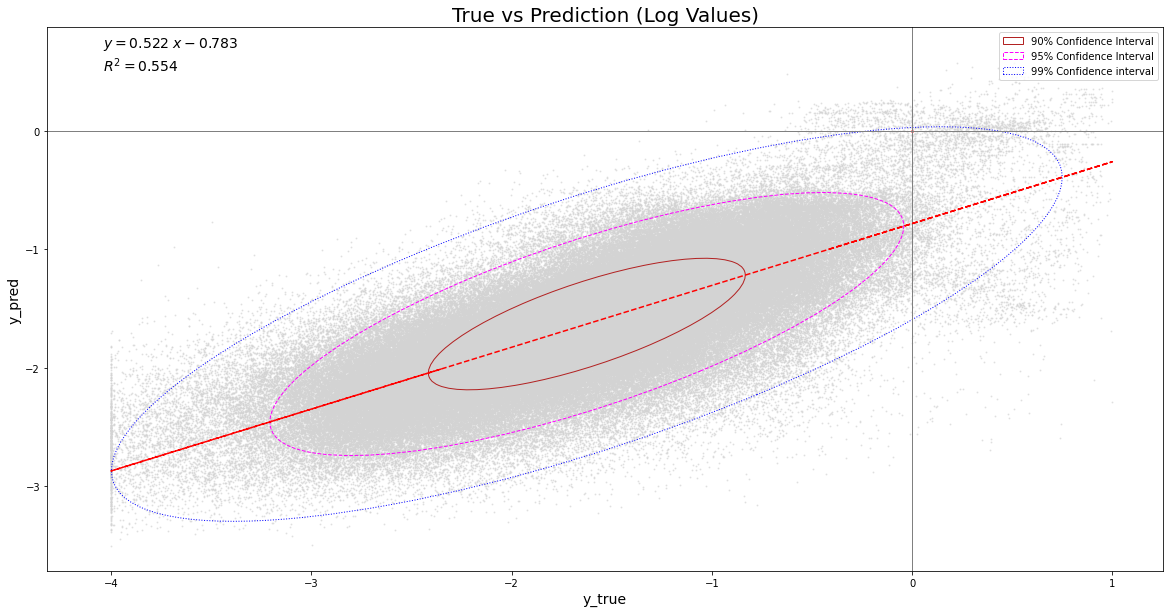

In [22]:
fig, ax_nstd = plt.subplots(figsize=(20, 10))

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x, y = df1["y_true"], df1["y_pred"]


confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'90% Confidence Interval', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'95% Confidence Interval', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'99% Confidence interval', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.legend(loc= "upper right")
plt.scatter(x, y, c='lightgrey', s=1, alpha=.5)
plt.xlabel("y_true", fontsize=14)
plt.ylabel("y_pred", fontsize=14)
plt.title("True vs Prediction (Log Values)", fontsize=20)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
y_hat = np.poly1d(z)(x)
plt.plot(x,p(x),"r--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='center')
plt.show()

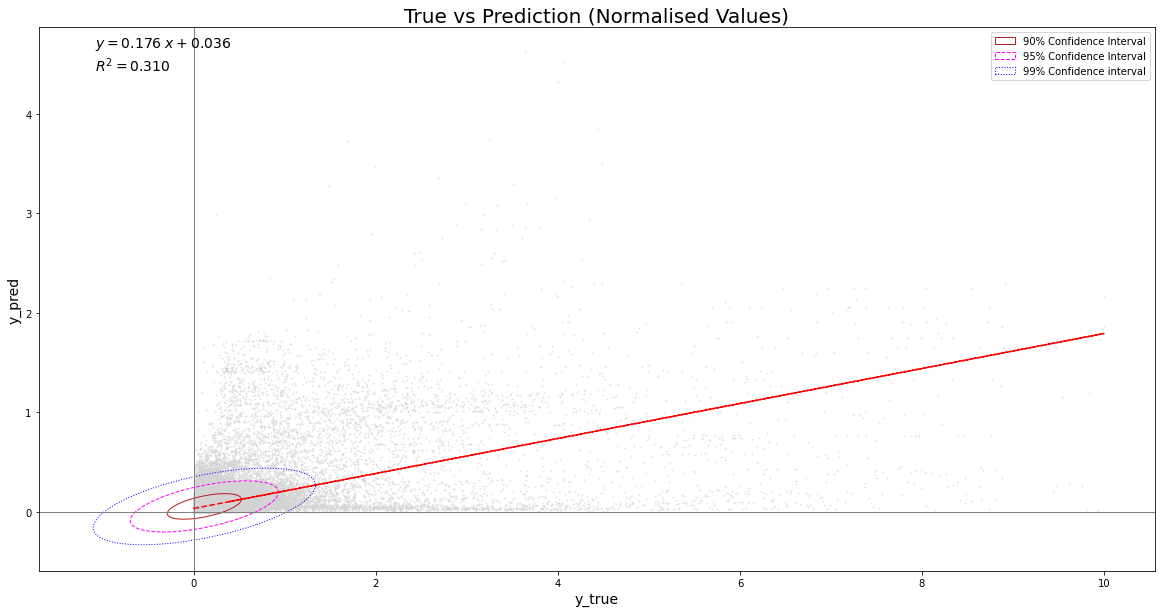

In [21]:
fig, ax_nstd = plt.subplots(figsize=(20, 10))

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

a, b = df3["y_true"], df3["y_pred"]


confidence_ellipse(a, b, ax_nstd, n_std=1,
                   label=r'90% Confidence Interval', edgecolor='firebrick')
confidence_ellipse(a, b, ax_nstd, n_std=2,
                   label=r'95% Confidence Interval', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(a, b, ax_nstd, n_std=3,
                   label=r'99% Confidence interval', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.legend(loc= "upper right")
plt.scatter(a, b, c='lightgrey', s=1, alpha=.5)
plt.xlabel("y_true", fontsize=14)
plt.ylabel("y_pred", fontsize=14)
plt.title("True vs Prediction (Normalised Values)", fontsize=20)
z = np.polyfit(a, b, 1)
p = np.poly1d(z)
n_hat = np.poly1d(z)(a)
plt.plot(a,p(a),"r--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(b,n_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='center')
plt.show()